# Kernel Trick

###  <div align=center> Moon Il-chul(icmoon@kaist.ac.kr); Kim Hye-mi(khm0308@kaist.ac.kr); Na Byeong-hu(wp03052@kaist.ac.kr) </div>

### Kernel function
Kernel이란 기존과 다른 차원의 공간에서의 두 벡터의 내적값을 의미합니다. 이를 수식으로 나타내면 다음과 같습니다.
$$K(x_i, x_j) = \phi(x_i) \cdot \phi(x_j)$$

커널 함수의 기존의 두점을 다른 차원으로 변환한 후 구한 내적 값과, 기존 차원에서의 내적값을 다른 차원으로 변환한 값이 같다는 특징이 있습니다. 더불어 커널 함수는 다양한 형태로 정의할 수 있습니다.

### Dual SVM과 Kernel
앞의 SVM Expanded Dimension 코드에서 보았듯, 선형 decision boundary로 분리하기 어려운 데이터는 차원 확장을 통해 비선형 decision boundary로 분류하였습니다. 더불어 SVM Dual Form 코드에서는 Primal 문제와 Dual 문제의 값이 (KKT 조건을 만족할 때) 동일한 것을 확인하였습니다. 이를 종합하면 SVM의 목적식을 다음과 같이 바꿀 수 있습니다.
$$max_{\alpha \geq 0} \sum_{j}\alpha_j - \frac{1}{2}\sum_{i}\sum_{j}\alpha_i\alpha_j y_i y_j \phi(x_i) \phi(x_j)$$  
여기서 앞서 설명하였듯 $\phi(x_i) \phi(x_j)$는 커널 함수 $K(x_i, x_j)$로 대체할 수 있습니다. 따라서 목적 함수와 조건식은 최종적으로 다음과 같이 나타납니다.
$$max_{\alpha \geq 0} \sum_{j}\alpha_j - \frac{1}{2}\sum_{i}\sum_{j}\alpha_i\alpha_j y_i y_j K(x_i, x_j)$$ 
$$s.t. \alpha_i ((wx_j+b)y_j - 1) = 0, \forall i$$
$$\sum_{i}^{N} \alpha_i y_i = 0 $$
$$ C > \alpha_i > 0, \forall i$$  
KKT 조건에 의해 $w$와 $b$는 다음과 같이 바뀝니다.
$$w=\sum_{i=1}^{N} \alpha_i y_i \phi(x_i)$$
$$b=y_i - \sum_{i=1}^{N} \alpha_i y_i \phi(x_i) \phi(x_j)$$

여기서 $b$의 $\phi(x_i) \phi(x_j)$는 Kernel값으로 대체할 수 있으나 $w$에 여전히 $\phi(x_i)$가 남아있습니다. 그런데 SVM의 목적이 $f(x) = w\phi(x) + b$값을 통해 데이터가 Postivie인지 Negative인지 분류하기 위함을 감안한다면, $f(x)$의 부호값을 통해 데이터를 분류할 수 있습니다.
$$sign(w \cdot \phi(x) + b) = sign(\sum_{i}^{N} \alpha_i y_i \phi(x_i) \phi(x) + y_j - \sum_{i}^{N} \alpha_i y_i \phi(x_i) \phi(x_j)) = sign(\sum_{i}^{N} \alpha_i y_i K(x_i, x) + y_j - \sum_{i}^{N} \alpha_i y_i K(x_i, x_j)), 0 < \alpha_j < C$$


In [1]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Kim Hye-mi: khm0308@kaist.ac.kr; Na Byeong-hu: wp03052@kaist.ac.kr
'''
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# 다양한 형태의 커널함수
def Kernel(X1, X2):
    selection = 2
    param = 5
    param1 = 1000
    param2 = -100
    
    if selection == 1:
        return pow(np.dot(X1, X2), param)
    elif selection == 2:
        return pow(np.dot(X1, X2) + 1, param)
    elif selection == 3:
        return np.exp(-param * np.dot((X1-X2), (X1-X2)))
    elif selection == 4:
        return np.tanh(np.dot(X1, X2)*param1 + param2)        

In [3]:
# Positive / Negative 데이터 생성
pos = np.array([[3, 7], [4, 6], [5, 6], [7, 7], [8, 5], [5, 5.2], [7, 5], [6, 3.75], [6, 4], [6, 5], [7, 5], [6, 4.5], [7, 4.5]])
neg = np.array([[4, 5], [5, 5], [6, 3], [7, 4], [9, 4], [5, 4], [5, 4.5], [5, 3.5], [7, 3.5]])

# 절충 매개변수
C = 1

# X: 전체 데이터를 저장
X = np.ones((pos.shape[0]+neg.shape[0], 2)) 
X[0:pos.shape[0], :] = pos # 앞부분은 positive 데이터를 저장
X[pos.shape[0]:pos.shape[0]+neg.shape[0], :] = neg # 뒷부분은 negative 데이터를 저장

# Y: 전체 데이터에 대한 label을 저장
Y = np.ones(pos.shape[0] + neg.shape[0])
Y[0:pos.shape[0]] = 1 # 앞부분은 positive 데이터에 대한 label로 +1을 저장
Y[pos.shape[0]:pos.shape[0]+neg.shape[0]] = -1 # 뒷부분은 negative 데이터에 대한 label로 -1을 저장

In [4]:
# 목적함수에서 두 번째 항을 형성함: -1/2*∑∑αi*αj*yi*yj*K(xi, xj)
H = np.zeros((pos.shape[0] + neg.shape[0], pos.shape[0] + neg.shape[0]))
for i in range(pos.shape[0] + neg.shape[0]):
    for j in range(pos.shape[0] + neg.shape[0]):
        H[i,j] += Kernel(X[i,:], X[j, :]) * Y[i] * Y[j] * -1
        
# 목적함수에서 첫 번째 항을 형성함: ∑aj  
f = np.ones(pos.shape[0] + neg.shape[0])

# cvxopt에서 solvers.qp는 목적함수를 minimize하므로 maximize하기 위해서는 -를 붙여야 함
# 즉, max ∑aj - 1/2*∑∑αi*αj*yi*yj*K(xi, xj) = min -∑aj + 1/2*∑∑αi*αj*yi*yj*K(xi, xj)
H = -1*H
f = -1*f

# A와 b는 0 < ai < C 조건식을 형성함
A = np.zeros((pos.shape[0] + neg.shape[0] + pos.shape[0] + neg.shape[0], pos.shape[0] + neg.shape[0]))
b = np.zeros(pos.shape[0] + neg.shape[0] + pos.shape[0] + neg.shape[0])

for i in range(pos.shape[0] + neg.shape[0]):
    A[i, i] = -1 # ai > 0 (cvxopt에서 solvers.qp는 Ax =< b이므로 -1을 넣어줌)
    A[i + pos.shape[0] + neg.shape[0], i] = 1 # C > ai 
    b[i + pos.shape[0] + neg.shape[0]] = C # C > ai

# Aeq와 Beq는 ∑ai * yi = 0 조건식을 형성함
Aeq = np.zeros((1, pos.shape[0] + neg.shape[0]))
Beq = np.zeros((1, 1))

for i in range(pos.shape[0] + neg.shape[0]):
    Aeq[0, i] = Y[i]

f = matrix(f)
H = matrix(H)
A = matrix(A)
b = matrix(b)
Aeq = matrix(Aeq)
Beq = matrix(Beq)

# optimization problem을 풀어줌
# solvers.qp(H, f, A, b, Aeq, Beq): min 1/2xTHx+fTx s.t. Ax =< b, Aeq = Beq
sol = solvers.qp(H, f, A, b, Aeq, Beq)
alpha = sol['x']

     pcost       dcost       gap    pres   dres
 0: -3.4030e+00 -3.5670e+01  2e+02  2e+00  4e-07
 1: -2.3150e+00 -1.9002e+01  3e+01  4e-01  3e-07
 2: -1.1899e+00 -5.7673e+00  8e+00  7e-02  2e-07
 3: -4.9823e-01 -3.2847e+00  5e+00  3e-02  1e-07
 4: -1.4977e-01 -9.5865e-01  1e+00  5e-03  7e-08
 5: -1.3078e-01 -5.5394e-01  7e-01  2e-03  3e-08
 6: -6.0838e-02 -3.2035e-01  5e-01  1e-03  3e-08
 7: -1.4039e-02 -6.8070e-02  1e-01  2e-04  5e-09
 8: -4.6203e-03 -2.1672e-02  3e-02  6e-05  2e-09
 9: -1.7531e-03 -8.2261e-03  1e-02  2e-05  9e-10
10: -4.9195e-04 -1.9928e-03  2e-03  2e-06  3e-10
11: -3.1415e-04 -5.0324e-04  2e-04  2e-16  7e-11
12: -3.5881e-04 -4.0750e-04  5e-05  2e-16  6e-11
13: -3.7842e-04 -3.8454e-04  6e-06  2e-16  6e-11
14: -3.8041e-04 -3.8056e-04  2e-07  2e-16  7e-11
15: -3.8048e-04 -3.8049e-04  5e-09  1e-16  5e-11
Optimal solution found.


In [5]:
# b = y - ∑ai * yi * K(xi, xj)
bs = np.zeros(X.shape[0])
k = -1

for j in range(X.shape[0]):
    temp = 0
    for i in range(X.shape[0]):
        temp += alpha[i] * Y[i] * Kernel(X[i], X[j])
    bs[j] = Y[j] - temp
    
    if alpha[j] > 0.0001 and alpha[j] < C - 0.0001:
        k = j

b = bs[k]

# 각 데이터의 f값
# fj = w * ϕ(xj) + b = ∑ai * yi * K(xi, xj) + b
a = np.zeros(X.shape[0])
for j in range(X.shape[0]):
    temp = 0
    for i in range(X.shape[0]):
        temp += alpha[i] * Y[i] * Kernel(X[i, :], X[j, :])
    a[j] = temp + b

In [6]:
x1 = np.linspace(1, 10) # x1 = [1, 2, ..., 9, 10]
x2 = np.linspace(3, 7) # x2 = [3, ..., 7]
xx1, xx2 = np.meshgrid(x1, x2)

f = np.zeros((len(x1), len(x2)))

# 각 지점 (x1, x2)에서의 f값 계산
for i in range(len(x1)):
    for j in range(len(x2)):
        temp = [x1[i], x2[j]]
        f[j, i] = 0
        for k in range(len(alpha)):
            f[j, i] += alpha[k] * Y[k] * Kernel(X[k, :], temp)
        f[j, i] += b                

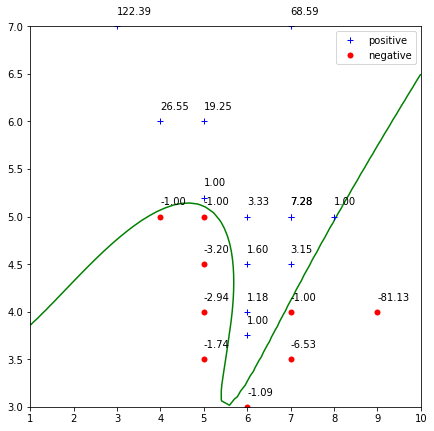

In [7]:
lev = np.arange(-10, 10, 5)
plt.figure(1, figsize = (7, 7))
# positive 데이터는 파랑색 +로 표시
plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'b+', label = 'positive')
# negative 데이터는 빨강색 o로 표시
plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], 
         X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', markeredgecolor = 'None', label = 'negative')

# 그래프 범위 내에서 f값이 0인 지점을 초록색으로 나타냄
c = plt.contour(x1, x2, f, levels = [0], colors = 'g', linestyles = 'solid')
plt.legend()
for i in range(X.shape[0]):
    plt.text(X[i, 0], X[i, 1], '%.2f\n'%(a[i]))


### 결과해석부
파랑색 +는 positive 데이터를, 빨강색 o는 negative 데이터를 의미합니다. 각 점에 적혀있는 값은 $x1$과 $x2$에 대한 $f(x)$값을 의미합니다. 초록색 선은 $f(x)$값이 0인 지점으로, 해당 데이터의 비선형 decision boundary의 역할을 수행합니다. 이 decisino boundary는 positive 데이터와 negative 데이터를 구분하고 있음을 확인할 수 있습니다.

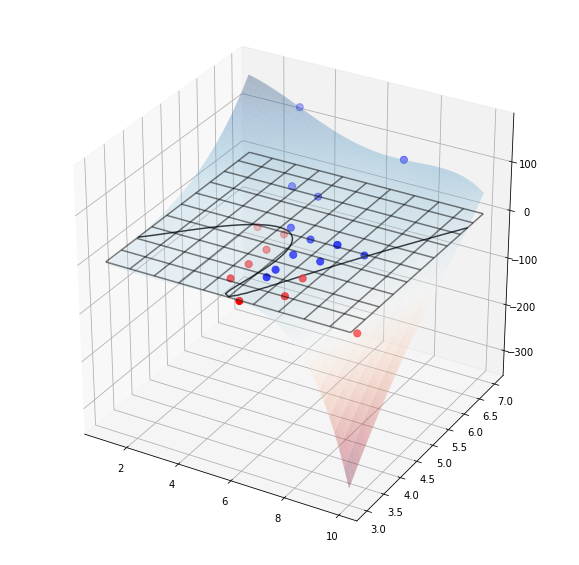

In [8]:
%matplotlib qt
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(1, 1, 1, projection='3d')

# positive 데이터는 빨강색으로 표시
ax.scatter(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], a[0:pos.shape[0]], c = 'b', s = 50)
# negative 데이터는 빨강색으로 표시
ax.scatter(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], 
           X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 
           a[pos.shape[0]:pos.shape[0] + neg.shape[0]], c = 'r', s = 50)
ax.plot_surface(xx1, xx2, f, rstride=1, cstride=1, cmap='RdBu', alpha = 0.3)

# 격자표시
ax.plot_wireframe(xx1, xx2, np.zeros((len(x1), len(x2))), rstride=5, cstride=5, color = 'k', alpha = 0.5)

# f값이 0인 지점을 검은색 선으로 표시
plt.contour(x1, x2, f, levels = [0], colors = 'k', linestyles = 'solid')
plt.show()

### 결과해석부

위 그래프는 앞의 그래프를 3차원으로 나타낸 것입니다. 차원확장의 결과로 2차원에 위치한 Positive 데이터(파랑색 점)와 Negative 데이터(빨강색 점)은 추가된 z축에서 각 점의 $f(x)$값을 가집니다. Positive 데이터와 Negative 데이터는 각각 양과 음의 값을 가져 z값이 0인 평면을 기준으로 두 데이터 셋이 나뉘는 것을 확인할 수 있습니다. 이 때의 z평면에서, f값이 0인 지점이 곧 두 데이터를 나누는 비선형 decision boundary가 되며 해당 그래프에서 검은색 실선으로 나타납니다.